In [15]:
import cv2
import numpy as np
from commonfunctions import *
import imutils

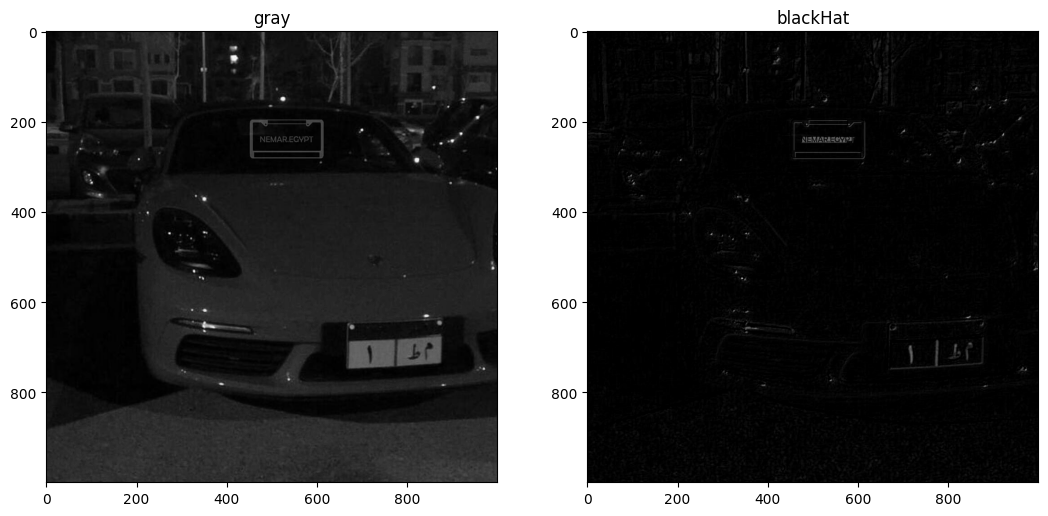

In [16]:
img_path = 'Dataset\\Vehicles\\0998.jpg'
image = cv2.imread(img_path)  # Load your image

image_copy = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
# enhance contrast using histogram equalization
gray = cv2.equalizeHist(gray)
gray_original = gray.copy()
blackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, cv2.getStructuringElement(cv2.MORPH_RECT, (10, 4)))
show_images([gray,blackHat], ["gray","blackHat"])

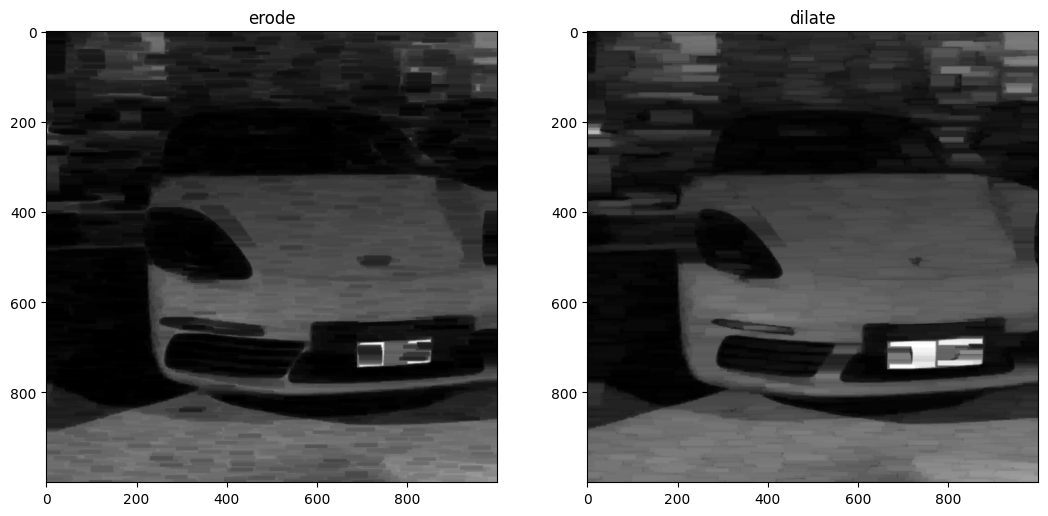

In [17]:
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 4))
erode = cv2.erode(gray, rectKernel, iterations=2)
dilate = cv2.dilate(erode, rectKernel, iterations=2)
show_images([erode, dilate], ["erode", "dilate"])

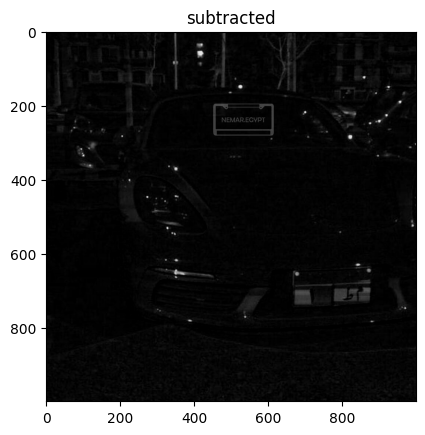

In [18]:
subtracted = cv2.subtract(gray, dilate)
show_images([subtracted], ["subtracted"])

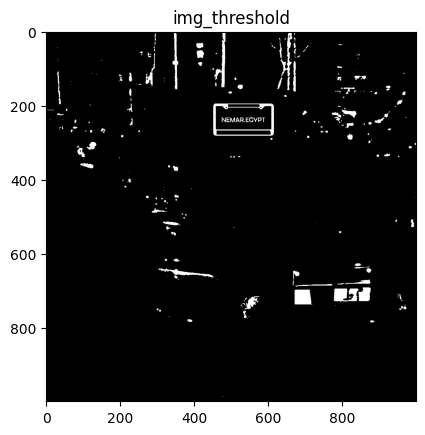

In [19]:
# max1 = np.max(subtracted)
# min1 = np.min(subtracted)
# threshold = (max1 - (max1 - min1)/1.35)/255
# img_threshold = cv2.threshold(subtracted, threshold, 255, cv2.THRESH_BINARY)[1]
# blackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)
# show_images([blackHat], ["blackHat"])
img_threshold = cv2.threshold(subtracted, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
show_images([img_threshold], ["img_threshold"])

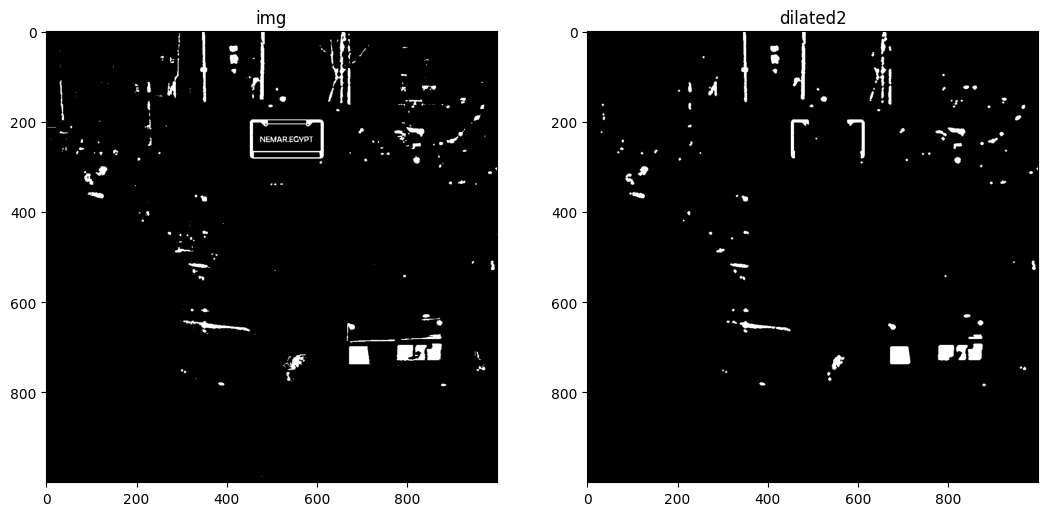

In [20]:
# diamond kernel for morphological operations write it manually
kernel_data = np.array([[0, 0, 1, 0, 0],
                        [0, 1, 1, 1, 0],
                        [1, 1, 1, 1, 1],
                        [0, 1, 1, 1, 0],
                        [0, 0, 1, 0, 0]], dtype=np.uint8)
eroded2 = cv2.erode(img_threshold, kernel_data, iterations=1)
dilated2 = cv2.dilate(eroded2, kernel_data, iterations=1)
show_images([img_threshold, dilated2], ["img", "dilated2"])

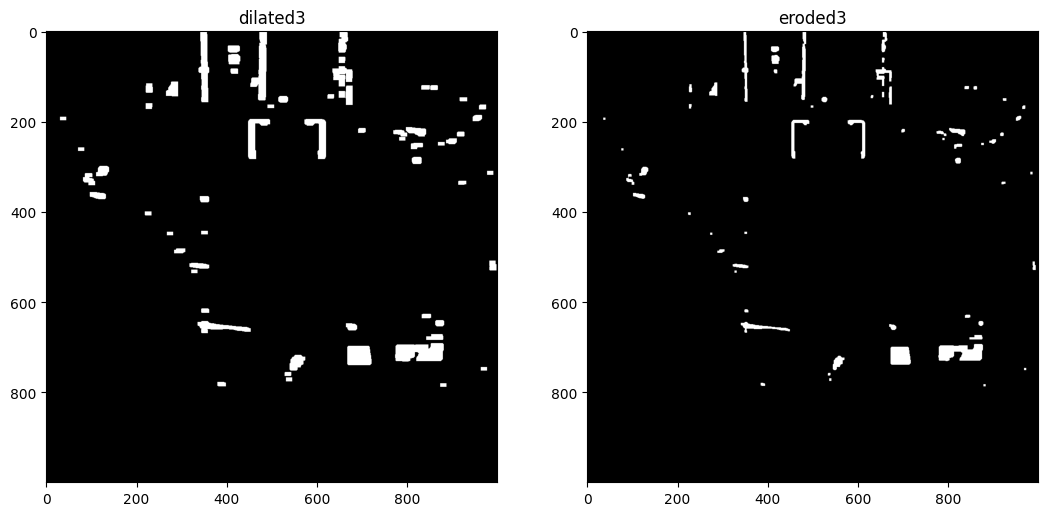

In [21]:
kern2 = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 4))
# show kernel
eroded6 = cv2.erode(dilated2, None, iterations=2)
dilated6 = cv2.dilate(eroded6, None, iterations=2)

dilated3 = cv2.dilate(dilated6, kern2, iterations=1)
eroded3 = cv2.erode(dilated3, kern2, iterations=1)
show_images([dilated3, eroded3], ["dilated3", "eroded3"])

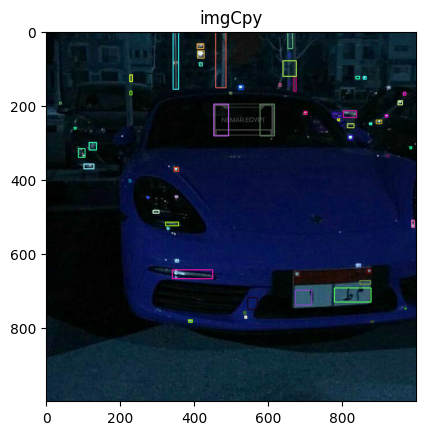

In [22]:
#find contours
cnts = cv2.findContours(eroded3.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
imgCpy = image.copy()
for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    rand_color = np.random.randint(0, 255, size=3).tolist()
    cv2.rectangle(imgCpy, (x, y), (x + w, y + h), rand_color, 2)
show_images([imgCpy], ["imgCpy"])

In [23]:
def get_component_chars(image):
    image_canny = cv2.Canny(image, 100, 200)
    image_thresh = cv2.threshold(image_canny, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    # find components
    connectedComponents = cv2.connectedComponentsWithStats(image_thresh, 4, cv2.CV_32S)
    (numLabels, labels, stats, centroids) = connectedComponents
    charList = []
    output = image.copy()
    #make output colored
    output = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)
    for i in range(0, numLabels):
        # if this is the first component then we examine the
        # *background* (typically we would just ignore this
        # component in our loop)
        if i == 0:
            text = "examining component {}/{} (background)".format(
                i + 1, numLabels)
        # otherwise, we are examining an actual connected component
        else:
            text = "examining component {}/{}".format(i + 1, numLabels)
        # print a status message update for the current connected
        # component
        print("[INFO] {}".format(text))
        # extract the connected component statistics and centroid for
        # the current label
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[i]
        aspectRatio = w / h
        # clone our original image (so we can draw on it) and then draw
        # a bounding box surrounding the connected component along with
        # a circle corresponding to the centroid
        if aspectRatio > 2 and aspectRatio < 4:
            cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 1)
            cv2.circle(output, (int(cX), int(cY)), 4, (0, 0, 255), -1)
    # show the output image
    show_images([image,output], ["original","output"])

In [24]:
def get_plate_variance(rectangle):
        x, y, w, h = rectangle
        rect_blackHat = blackHat[y:y+h, x:x+w]
        rect_blackHat = cv2.threshold(
            rect_blackHat, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
        cnts = cv2.findContours(rect_blackHat.copy(),
                                cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        cnts_filtered = []
        filtered_rectangles = []
        cnt_vertical_letters = 0
        
        center = h/2 + (h/2)*0.2
        # delete very small or very large rectangle.
        for c in cnts:
            (x, y, w, h) = cv2.boundingRect(c)
            area = w*h
            if area > 50 and area < 1000:
                print(h/w)
                print(f"y:{y} center:{center} y+h:{y+h}")
                if h/w >= 1 and y <= center <= y+h :
                    cnt_vertical_letters += 1
                filtered_rectangles.append((x, y, w, h))

        vertical_centers = []
        for rect in filtered_rectangles:
            x, y, w, h = rect
            vertical_centers.append(y+h/2)

        variance = np.var(vertical_centers)
        # variance from the center of the image
        vertical_centers = np.array(vertical_centers)
        variance = np.var(vertical_centers - center)
        if (len(filtered_rectangles) < 2):
            variance = 1000
        #draw rectangles
        imgCpy = rect_blackHat.copy()
        for c in filtered_rectangles:
            (x, y, w, h) = c
            rand_color = np.random.randint(0, 255, size=3).tolist()
            cv2.rectangle(imgCpy, (x, y), (x + w, y + h), rand_color, 2)
        show_images([imgCpy], ["imgCpy"])
        print(f"vertical letters: {cnt_vertical_letters}")
        return cnt_vertical_letters

In [25]:
import math

9.333333333333334
y:10 center:22.8 y+h:38
2.1176470588235294
y:0 center:22.8 y+h:36
1.1379310344827587
y:0 center:22.8 y+h:33


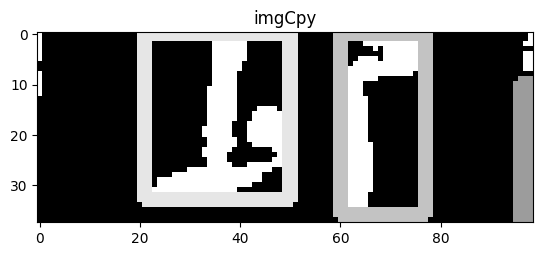

vertical letters: 3
0.030303030303030304


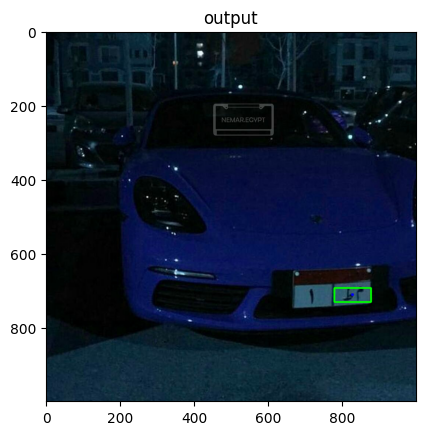

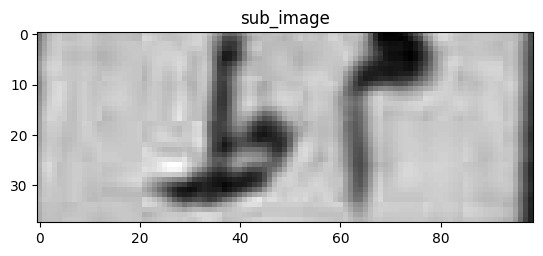

In [26]:
connectedComponents = cv2.connectedComponentsWithStats(eroded3, 4, cv2.CV_32S)
(numLabels, labels, stats, centroids) = connectedComponents
output = image.copy()
# loop over the number of unique connected component labels
# get nearest five label center to the center of the image
label_centers = []
imgXCenter = int(image.shape[1] / 2)
imgYCenter = int(image.shape[0] / 2)
for i in range(0, numLabels):
    ecludian_distance = np.sqrt((imgXCenter - centroids[i][0]) ** 2 + (imgYCenter - centroids[i][1]) ** 2)
    label_centers.append((ecludian_distance, i))
    
label_centers = sorted(label_centers, key=lambda x: x[0])
plates = []
k = 5
iterations = numLabels
for i in range(0, iterations):
    currIdx = label_centers[i][1]
    x = stats[currIdx, cv2.CC_STAT_LEFT]
    y = stats[currIdx, cv2.CC_STAT_TOP]
    w = stats[currIdx, cv2.CC_STAT_WIDTH]
    h = stats[currIdx, cv2.CC_STAT_HEIGHT]
    area = stats[currIdx, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[currIdx]
    aspectRatio = w / h
    # clone our original image (so we can draw on it) and then draw
    # a bounding box surrounding the connected component along with
    # a circle corresponding to the centroid
    if aspectRatio > 1.7 and aspectRatio < 8 and area > 1200:
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
        cv2.circle(output, (int(cX), int(cY)), 4, (0, 0, 255), -1)
        # mask = (labels == i).astype("uint8") * 255
        # masks.append(mask)
        cnt = get_plate_variance((x, y, w, h))
        # if variance < 180:
        #     continue
        # represent cnt and variance in a single number goal to have large cnt and small variance
        cost = cnt/w
        print(cost)
        plates.append((cost, (x, y, w, h)))
        # sub_image = gray_original[y:y + h, x:x + w]
        # show_images([sub_image], ["sub_image"])
        # get_component_chars(sub_image)
# show the output image
show_images([output], ["output"])
plates = sorted(plates, key=lambda x: -x[0])
if len(plates) > 0:
    x, y, w, h = plates[0][1]
    cv2.rectangle(image_copy, (x, y), (x + w, y + h), (0, 255, 0), 3)
    sub_image = gray_original[y:y + h, x:x + w]
    show_images([sub_image], ["sub_image"])
